In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xgboost as xgb

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score


In [25]:
og_train_df = pd.read_csv('./data/train.csv')
new_train_df = pd.read_csv('./data/train_new.csv')

og_test_df = pd.read_csv('./data/test.csv')
new_test_df = pd.read_csv('./data/test_new.csv')

train_df = pd.concat([og_train_df, new_train_df], axis=1)
test_df = pd.concat([og_test_df, new_test_df], axis=1)

#### **Part 1: Exploration**

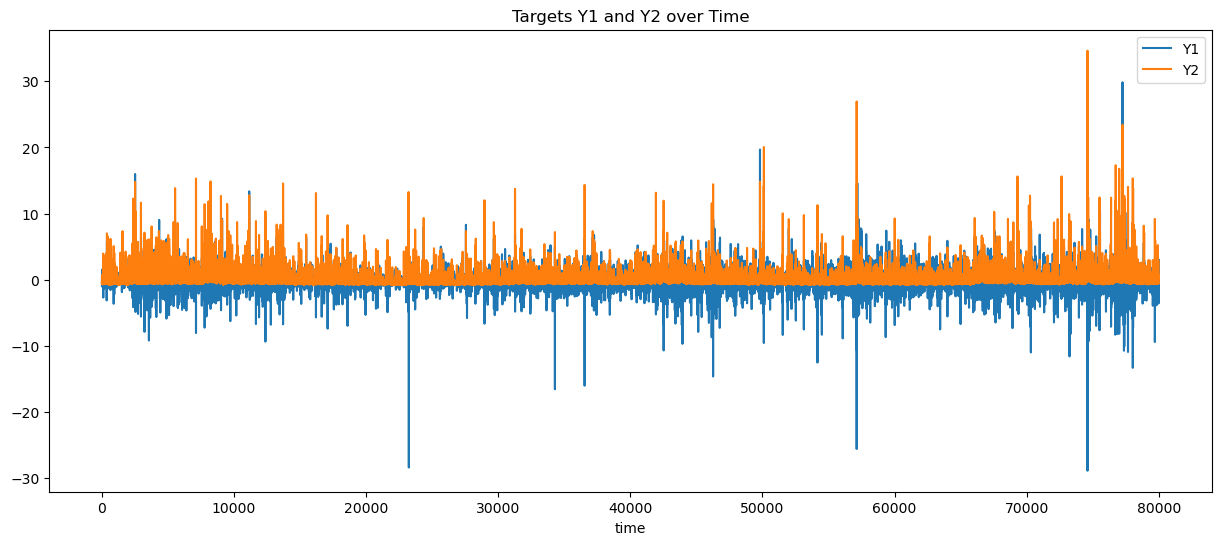

In [26]:
fig, ax = plt.subplots(figsize=(15, 6))
train_df.plot(x='time', y=['Y1', 'Y2'], ax=ax, title='Targets Y1 and Y2 over Time')
plt.show()

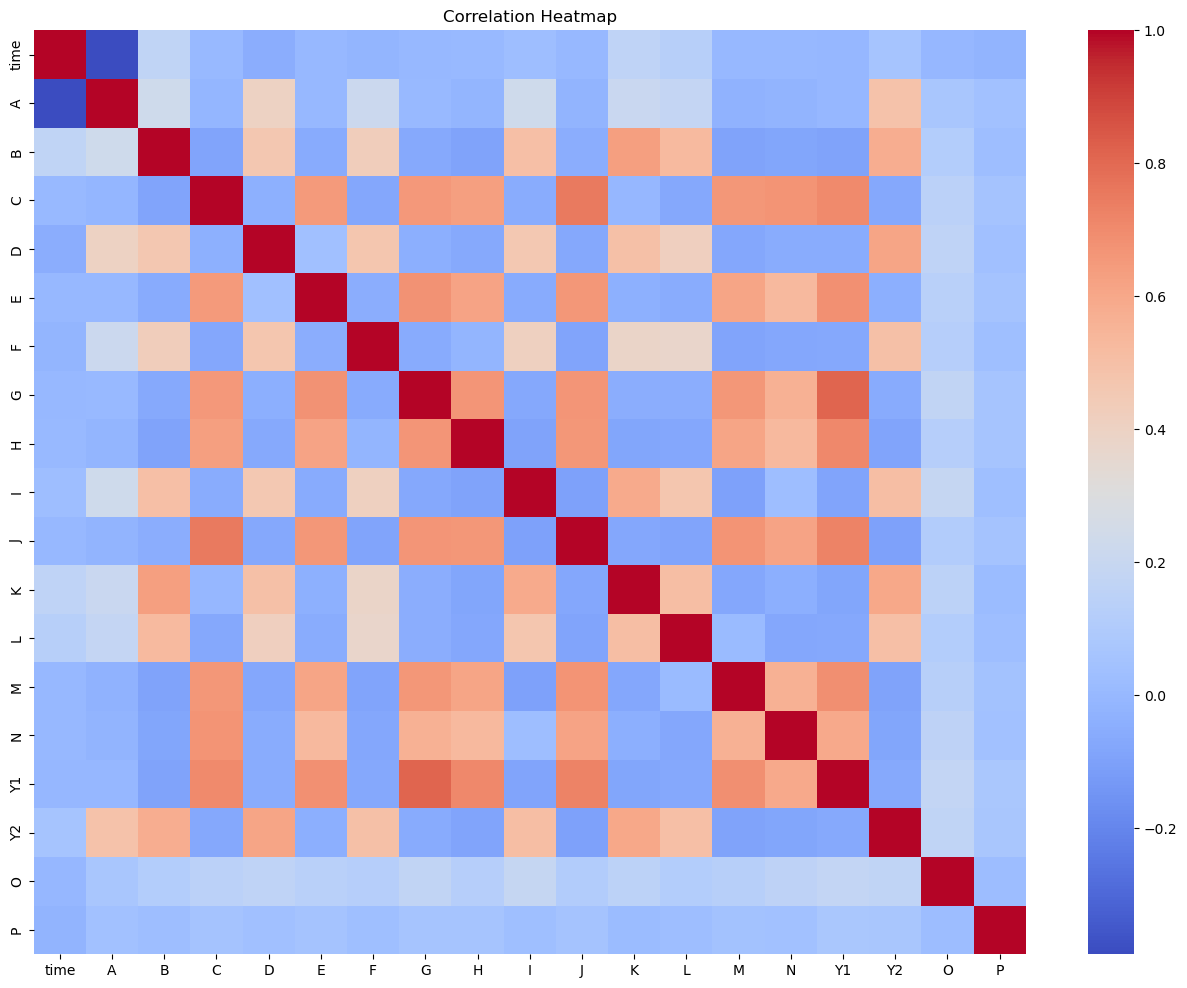

In [27]:
correlation_matrix = train_df.corr()
plt.figure(figsize=(16,12))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap')
plt.show()

In [28]:
print(correlation_matrix[['Y1', 'Y2']].sort_values(by='Y1', ascending=False))

            Y1        Y2
Y1    1.000000 -0.064250
G     0.814568 -0.060187
J     0.723921 -0.097986
H     0.707560 -0.086976
C     0.703823 -0.073009
M     0.686246 -0.095326
E     0.684297 -0.044583
N     0.595766 -0.080172
O     0.177676  0.167684
P     0.074776  0.069005
time -0.005645  0.059143
A    -0.006105  0.484746
D    -0.057097  0.611063
Y2   -0.064250  1.000000
L    -0.072366  0.503546
F    -0.073191  0.496667
K    -0.080196  0.599183
I    -0.090226  0.508347
B    -0.094995  0.581859


#### **Part 2: Actual Algo**

In [29]:
combined_df = pd.concat([train_df.drop(['Y1', 'Y2'], axis=1), test_df], ignore_index=True)

combined_df['O'].fillna(-1, inplace=True)
combined_df['P'].fillna(-1, inplace=True)

continuous_features = ['G', 'J', 'H', 'C', 'M', 'E', 'N', 'A', 'D', 'K', 'B', 'I', 'L', 'F']
binary_features = ['O', 'P']

for col  in continuous_features:
    for lag in [1, 3, 5]:
        combined_df[f'{col}_lag_{lag}'] = combined_df[col].shift(lag)
    for window in [10, 30]:
        combined_df[f'{col}_roll_mean_{window}'] = combined_df[col].rolling(window=window).mean()
        combined_df[f'{col}_roll_std_{window}'] = combined_df[col].rolling(window=window).std()

for col  in binary_features:
    for lag in [1, 2, 3]:
        combined_df[f'{col}_lag_{lag}'] = combined_df[col].shift(lag)
    for window in [10, 30]:
        combined_df[f'{col}_roll_sum_{window}'] = combined_df[col].rolling(window=window).sum()

train_processed = combined_df.iloc[:len(train_df)].assign(Y1=train_df['Y1'], Y2=train_df['Y2'])
test_processed = combined_df.iloc[len(train_df):]

train_processed.fillna(method='bfill', inplace=True)
test_processed.fillna(method='bfill', inplace=True)
train_processed.fillna(0, inplace=True)
test_processed.fillna(0, inplace=True)

C:\Users\Minlong\AppData\Local\Temp\ipykernel_19240\2820958949.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_df['O'].fillna(-1, inplace=True)
C:\Users\Minlong\AppData\Local\Temp\ipykernel_19240\2820958949.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl

In [30]:
features = [col for col in train_processed.columns if col not in ['id', 'time', 'Y1', 'Y2']]
X_train = train_processed[features]
y1_train = train_processed['Y1']
y2_train = train_processed['Y2']
X_test = test_processed[features]

In [31]:
xgb_y1 = xgb.XGBRegressor(
    objective='reg:absoluteerror',
    random_state=42,
    n_estimators=2000,
    learning_rate=0.02,
    max_depth=8,
    min_child_weight=3,
    subsample=0.85,
    colsample_bytree=0.85,
    colsample_bylevel=0.85,
    reg_alpha=0.1,
    reg_lambda=1.0,
    gamma=0.1,
    n_jobs=-1
)
xgb_y1.fit(X_train, y1_train)

xgb_y2 = xgb.XGBRegressor(
    objective='reg:absoluteerror',
    random_state=42,
    n_estimators=1500,
    learning_rate=0.03,
    max_depth=6,
    n_jobs=-1
)
xgb_y2.fit(X_train, y2_train)

,objective,'reg:absoluteerror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [33]:
predictions_y1 = xgb_y1.predict(X_test)
predictions_y2 = xgb_y2.predict(X_test)

submission_df = pd.DataFrame({
    'id': test_df['id'],
    'Y1': predictions_y1,
    'Y2': predictions_y2
})

submission_df.to_csv('submission_xgb.csv', index = False)
print(submission_df.head())

   id        Y1        Y2
0   1  0.436878 -0.231150
1   2 -0.188874 -0.326903
2   3 -0.211462 -0.222510
3   4 -0.350244 -0.164572
4   5 -0.814058 -0.125100
